In [1]:
from zipfile import ZipFile

In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
with ZipFile('/content/chest-xray-pneumonia.zip','r') as zipobj:
  zipobj.extractall("/content/chest_xray")

100% 2.29G/2.29G [00:20<00:00, 180MB/s]
100% 2.29G/2.29G [00:20<00:00, 119MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

In [3]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from torch import nn
import torch.optim as optim
from pathlib import Path
from torch import nn

In [4]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0], std=[1])
])

In [5]:
train_data = ImageFolder("/content/chest_xray/chest_xray/train", transform = transform)
test_data = ImageFolder("/content/chest_xray/chest_xray/test", transform = transform)
validation_data = ImageFolder("/content/chest_xray/chest_xray/val", transform = transform)
image, label = train_data[0]
print(image.shape, label)
print(image)

torch.Size([1, 224, 224]) 0
tensor([[[0.0863, 0.0784, 0.0745,  ..., 0.3725, 0.3725, 0.3725],
         [0.0863, 0.0824, 0.0745,  ..., 0.3647, 0.3725, 0.3725],
         [0.0902, 0.0824, 0.0745,  ..., 0.3647, 0.3686, 0.3647],
         ...,
         [0.1176, 0.1137, 0.1098,  ..., 0.2353, 0.2353, 0.2353],
         [0.1373, 0.1373, 0.1333,  ..., 0.3176, 0.3216, 0.3216],
         [0.1765, 0.1765, 0.1765,  ..., 0.4196, 0.4235, 0.4235]]])


Image Shape :  torch.Size([1, 224, 224])


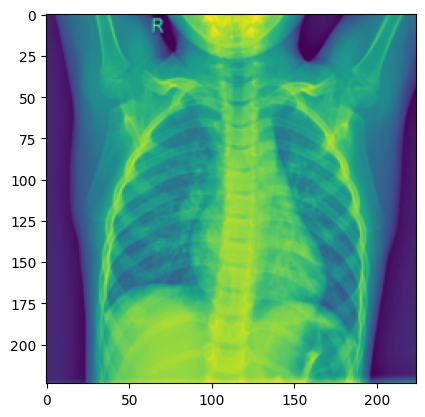

In [6]:
image, label = train_data[0]
print("Image Shape : ", image.shape)
plt.imshow(image.squeeze())
plt.show()

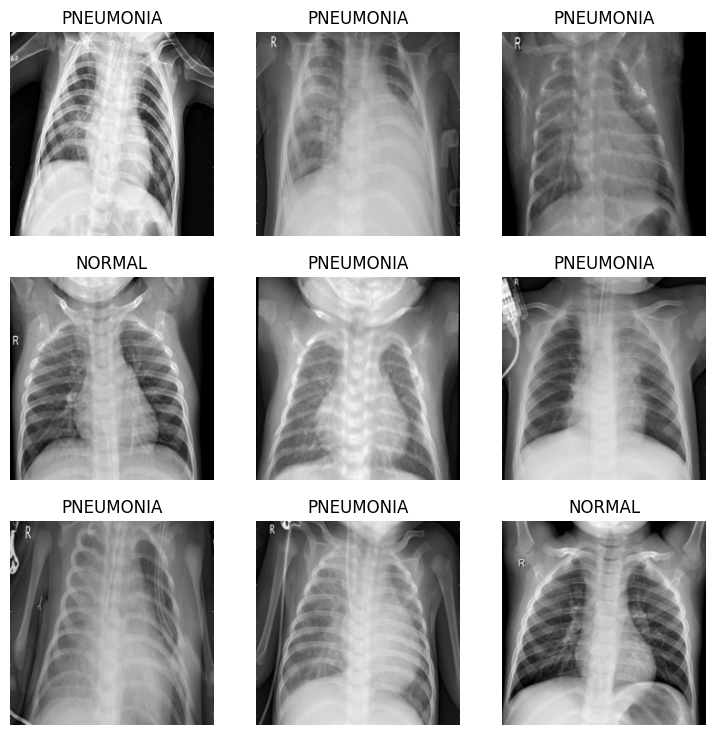

In [7]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, columns = 3,3
count = 1
for i in range(rows):
  for j in range(columns):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, columns, count)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(train_data.classes[label])
    plt.axis(False)
    count=count+1

In [27]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [9]:
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)
train_dataloader

In [15]:
class_names = train_data.classes
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape, class_names

(torch.Size([32, 3, 224, 224]), torch.Size([32]), ['NORMAL', 'PNEUMONIA'])

In [ ]:
class CNN_6Layer_Model(nn.Module):
  def __init__(self, input_shape, output_shape):
    super().__init__()
    self.layer_stack1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32,
                  kernel_size=3, stride=1, padding=1),
        nn.ReLU() ##224, 224
    )
    self.layer_stack2 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=32,
                  kernel_size=3, stride=1, padding=1),
        nn.ReLU(),  #224, 224
        nn.MaxPool2d(kernel_size=2, stride=2) #112, 112
    )
    self.layer_stack3 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=32,
                  kernel_size=3, stride=1, padding=1),
        nn.ReLU()  #112, 112
    )
    self.layer_stack4 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=32,
                  kernel_size=3, stride=1, padding=1),
        nn.ReLU(), #112, 112
        nn.MaxPool2d(kernel_size=2, stride=2) #56, 56
    )
    self.final_stack = nn.Sequential(
        nn.Flatten(), #56*56
        nn.Linear(in_features=56*56*32, out_features = output_shape) #
    )
  def forward(self,x):
    x = self.layer_stack1(x)
    x = self.layer_stack2(x)
    x = self.layer_stack3(x)
    x = self.layer_stack4(x)
    x = self.final_stack(x)
    return x

model_CNN_4layer = CNN_6Layer_Model(1, 2)
model_CNN_4layer

CNN_6Layer_Model(
  (layer_stack1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (layer_stack2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer_stack3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (layer_stack4): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (final_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=2, bias=True)
  )
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(params = model_CNN_4layer.parameters(),
                      lr = 0.1)

In [23]:
def train_step(model, data_loader, loss_fn, optimizer, accuracy_fn, device):
  train_loss=0
  train_acc=0
  model.to(device)
  for batch, (X, y) in enumerate(data_loader):
    X,y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_true=y,
                             y_pred=y_pred.argmax(dim=1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(model, data_loader, loss_fn, optimizer, accuracy_fn, device):
  test_loss=0
  test_acc=0
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for X,y in data_loader:
      X,y = X.to(device), y.to(device)

      test_pred = model(X)

      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true = y, y_pred = test_pred.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

def validation_step(model, data_loader, loss_fn, optimizer, accuracy_fn, device):
  val_loss=0
  val_acc=0
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for X,y in data_loader:
      X,y = X.to(device), y.to(device)

      val_pred = model(X)

      val_loss += loss_fn(val_pred, y)
      val_acc += accuracy_fn(y_true = y, y_pred = val_pred.argmax(dim=1))

    val_loss /= len(data_loader)
    val_acc /= len(data_loader)
    print(f"Validation loss: {val_loss:.5f} | Validation accuracy: {val_acc:.2f}%\n")

In [24]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [25]:
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [ ]:
torch.manual_seed(42)
from tqdm.auto import tqdm
from helper_functions import accuracy_fn
# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model
epochs = 10
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
        model=model_CNN_4layer,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model_CNN_4layer,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device,optimizer = optimizer
    )
    test_step(data_loader=validation_dataloader,
        model=model_CNN_4layer,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device,optimizer = optimizer
    )

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2,
                                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.57039 | Train accuracy: 74.29%
Test loss: 0.68860 | Test accuracy: 62.50%

Test loss: 0.81400 | Test accuracy: 50.00%

Epoch: 1
---------
Train loss: 0.57037 | Train accuracy: 74.29%
Test loss: 0.69395 | Test accuracy: 62.34%

Test loss: 0.82197 | Test accuracy: 50.00%

Epoch: 2
---------
Train loss: 0.57040 | Train accuracy: 74.29%
Test loss: 0.70250 | Test accuracy: 62.50%

Test loss: 0.84262 | Test accuracy: 50.00%

Epoch: 3
---------
Train loss: 0.57024 | Train accuracy: 74.29%
Test loss: 0.68937 | Test accuracy: 62.19%

Test loss: 0.80896 | Test accuracy: 50.00%

Epoch: 4
---------
Train loss: 0.57032 | Train accuracy: 74.29%
Test loss: 0.68935 | Test accuracy: 62.50%

Test loss: 0.81563 | Test accuracy: 50.00%

Epoch: 5
---------
Train loss: 0.57041 | Train accuracy: 74.29%
Test loss: 0.70291 | Test accuracy: 62.03%

Test loss: 0.83330 | Test accuracy: 50.00%

Epoch: 6
---------
Train loss: 0.57044 | Train accuracy: 74.29%
Test loss: 0.69694 | Tes

In [8]:
from torchvision.models import vgg16, VGG16_Weights
weights = VGG16_Weights.DEFAULT
weights

VGG16_Weights.IMAGENET1K_V1

In [9]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [10]:
train_data = ImageFolder("/content/chest_xray/chest_xray/train", transform = auto_transforms)
test_data = ImageFolder("/content/chest_xray/chest_xray/test", transform = auto_transforms)
validation_data = ImageFolder("/content/chest_xray/chest_xray/val", transform = auto_transforms)
image, label = train_data[0]
print(image.shape, label)
print(image)

torch.Size([3, 224, 224]) 0
tensor([[[-0.3369, -0.3198, -0.2684,  ..., -0.2513, -0.0972,  0.2967],
         [-0.3369, -0.3027, -0.2856,  ..., -0.2171,  0.1254,  0.5707],
         [-0.3541, -0.3027, -0.2856,  ..., -0.0629,  0.3481,  0.8447],
         ...,
         [-1.0562, -0.9705, -0.8507,  ..., -1.9809, -2.0665, -2.0323],
         [-1.0390, -0.9534, -0.8507,  ..., -2.0323, -2.0665, -2.0323],
         [-1.0390, -0.9534, -0.8335,  ..., -2.0494, -2.0494, -2.0323]],

        [[-0.2150, -0.1975, -0.1450,  ..., -0.1275,  0.0301,  0.4328],
         [-0.2150, -0.1800, -0.1625,  ..., -0.0924,  0.2577,  0.7129],
         [-0.2325, -0.1800, -0.1625,  ...,  0.0651,  0.4853,  0.9930],
         ...,
         [-0.9503, -0.8627, -0.7402,  ..., -1.8957, -1.9832, -1.9482],
         [-0.9328, -0.8452, -0.7402,  ..., -1.9482, -1.9832, -1.9482],
         [-0.9328, -0.8452, -0.7227,  ..., -1.9657, -1.9657, -1.9482]],

        [[ 0.0082,  0.0256,  0.0779,  ...,  0.0953,  0.2522,  0.6531],
         [ 0.0082

In [11]:
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)
train_dataloader

In [13]:
from torchinfo import summary
model = vgg16(weights=weights)
summary(model=model,
        input_size=(32,3, 224, 224),
        col_names=['input_size','output_size'],
        col_width=20,
        row_settings=['var_names']
        )

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 87.2MB/s]


Layer (type (var_name))                  Input Shape          Output Shape
VGG (VGG)                                [32, 3, 224, 224]    [32, 1000]
├─Sequential (features)                  [32, 3, 224, 224]    [32, 512, 7, 7]
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 224, 224]
│    └─ReLU (1)                          [32, 64, 224, 224]   [32, 64, 224, 224]
│    └─Conv2d (2)                        [32, 64, 224, 224]   [32, 64, 224, 224]
│    └─ReLU (3)                          [32, 64, 224, 224]   [32, 64, 224, 224]
│    └─MaxPool2d (4)                     [32, 64, 224, 224]   [32, 64, 112, 112]
│    └─Conv2d (5)                        [32, 64, 112, 112]   [32, 128, 112, 112]
│    └─ReLU (6)                          [32, 128, 112, 112]  [32, 128, 112, 112]
│    └─Conv2d (7)                        [32, 128, 112, 112]  [32, 128, 112, 112]
│    └─ReLU (8)                          [32, 128, 112, 112]  [32, 128, 112, 112]
│    └─MaxPool2d (9)                     

In [14]:
for param in model.features.parameters():
  param.requires_grad = False

In [20]:
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=25088,
              out_features=2,
              bias=True)
)

In [21]:
summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=['input_size','output_size'],
        col_width=20,
        row_settings=['var_names']
        )

Layer (type (var_name))                  Input Shape          Output Shape
VGG (VGG)                                [32, 3, 224, 224]    [32, 2]
├─Sequential (features)                  [32, 3, 224, 224]    [32, 512, 7, 7]
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 224, 224]
│    └─ReLU (1)                          [32, 64, 224, 224]   [32, 64, 224, 224]
│    └─Conv2d (2)                        [32, 64, 224, 224]   [32, 64, 224, 224]
│    └─ReLU (3)                          [32, 64, 224, 224]   [32, 64, 224, 224]
│    └─MaxPool2d (4)                     [32, 64, 224, 224]   [32, 64, 112, 112]
│    └─Conv2d (5)                        [32, 64, 112, 112]   [32, 128, 112, 112]
│    └─ReLU (6)                          [32, 128, 112, 112]  [32, 128, 112, 112]
│    └─Conv2d (7)                        [32, 128, 112, 112]  [32, 128, 112, 112]
│    └─ReLU (8)                          [32, 128, 112, 112]  [32, 128, 112, 112]
│    └─MaxPool2d (9)                     [32

In [22]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(params = model.parameters(),
                      lr = 0.1)

In [28]:
torch.manual_seed(42)
from tqdm.auto import tqdm
from helper_functions import accuracy_fn
# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model
epochs = 10
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device,optimizer = optimizer
    )
    test_step(data_loader=validation_dataloader,
        model=model,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device,optimizer = optimizer
    )

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2,
                                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 4.52181 | Train accuracy: 93.31%
Test loss: 4.31436 | Test accuracy: 90.31%

Test loss: 0.20590 | Test accuracy: 87.50%

Epoch: 1
---------
Train loss: 1.25646 | Train accuracy: 96.55%
Test loss: 12.61779 | Test accuracy: 82.81%

Test loss: 1.64463 | Test accuracy: 93.75%

Epoch: 2
---------
Train loss: 0.58456 | Train accuracy: 97.97%
Test loss: 14.68085 | Test accuracy: 79.22%

Test loss: 2.65041 | Test accuracy: 81.25%

Epoch: 3
---------
Train loss: 0.35826 | Train accuracy: 98.18%
Test loss: 30.06704 | Test accuracy: 69.38%

Test loss: 25.06220 | Test accuracy: 56.25%

Epoch: 4
---------
Train loss: 0.30428 | Train accuracy: 98.62%
Test loss: 13.60711 | Test accuracy: 78.59%

Test loss: 5.93116 | Test accuracy: 75.00%

Epoch: 5
---------
Train loss: 0.17270 | Train accuracy: 99.14%
Test loss: 16.17245 | Test accuracy: 78.12%

Test loss: 5.68796 | Test accuracy: 81.25%

Epoch: 6
---------
Train loss: 0.09004 | Train accuracy: 99.39%
Test loss: 12.6913